# Importing Packages Needed

In [1]:
import numpy as np

In [2]:
import scipy as sp

In [3]:
import matplotlib.pyplot as py

In [4]:
from scipy.optimize import curve_fit

In [5]:
from scipy.signal import find_peaks

In [6]:
import collections as col

In [7]:
import statistics

In [8]:
from scipy.interpolate import UnivariateSpline

# Definition of Named Tuples

In [9]:
component = col.namedtuple('component','phase intensity')

In [10]:
ind_component = col.namedtuple('component','phase intensity width')

In [11]:
pulse_component = col.namedtuple('pulse_component','frequency comp1 comp2 errors')

In [12]:
component_separation = col.namedtuple('component_separation','frequency separation')

# Definition of Functions

Gaussian Fitting Functions:

In [13]:
def chsq(observed_values, expected_values, err):
    """
    Chi Squared operation:
    Compute the data's chi squared values.
    
    Parameters:
    -----------
    observed_values: list
        A list of floats - the raw data
    expected_values: list
        A list of floats - the expected data or the fit
    err: float
        The error across all data - standard deviation of the noise

    Returns:
    --------
    test_statistic: float
        The chi squared value of the data
    
    Created by Keegan Smith
    """
    test_statistic=0
    for observed, expected in zip(observed_values, expected_values):
        test_statistic+=((float(observed)-float(expected))/float(err))**2
    return test_statistic

def chsq_err(observed_values, expected_values, err):
    #Same as above but used when there is a different error for each point
    test_statistic=0
    for observed, expected, error in zip(observed_values, expected_values, err):
        test_statistic+=((float(observed)-float(expected))/float(error))**2
    return test_statistic

In [14]:
def gauss(x,amp,cen,sd):
    return amp*np.exp(-(x-cen)**2/(2*sd**2))

def twogauss(x,amp1,cen1,sd1,amp2,cen2,sd2):
    return gauss(x,amp1,cen1,sd1)+gauss(x,amp2,cen2,sd2)

def threegauss(x,amp1,cen1,sd1,amp2,cen2,sd2,amp3,cen3,sd3):
    return gauss(x,amp1,cen1,sd1)+gauss(x,amp2,cen2,sd2)+gauss(x,amp3,cen3,sd3)

def fourgauss(x,amp1,cen1,sd1,amp2,cen2,sd2,amp3,cen3,sd3,amp4,cen4,sd4):
    return gauss(x,amp1,cen1,sd1)+gauss(x,amp2,cen2,sd2)+gauss(x,amp3,cen3,sd3)+gauss(x,amp4,cen4,sd4)

In [15]:
def fitting_parameters(x,y,expected):
    params,cov=curve_fit(threegauss,x,y,expected, bounds=([0,0,0,0,0,0,0,0,0],[np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf]))
    sigma=np.sqrt(np.diag(cov))
    return params, cov, sigma

def fittingtwo_parameters(x,y,expected):
    params,cov=curve_fit(twogauss,x,y,expected, bounds=([0,0,0,0,0,0],[np.inf,np.inf,np.inf,np.inf,np.inf,np.inf]))
    sigma=np.sqrt(np.diag(cov))
    return params, cov, sigma

def fittingfour_parameters(x,y,expected):
    params,cov=curve_fit(fourgauss,x,y,expected, bounds=([0,0,0,0,0,0,0,0,0,0,0,0],[np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf]))
    sigma=np.sqrt(np.diag(cov))
    return params, cov, sigma

Finding Peak of Fittings Function

In [16]:
def sigmaClip(data, alpha=3, tol=0.1, ntrials=10):
    """
    Sigma clipping operation:
    Compute the data's median, m, and its standard deviation, sigma.
    Keep only the data that falls in the range (m-alpha*sigma,m+alpha*sigma) for some value of alpha, and discard everything else.

    This operation is repeated ntrials number of times or until the tolerance level is hit.

    Parameters:
    -----------
    data: list
        A list of floats - the data to clip
    alpha: float
        OPTIONAL - Determines the number of sigmas to use to determine the upper nad lower limits. Default=3
    tol: float
        OPTIONAL - The fractional change in the standard deviation that determines when the tolerance is hit. Default=0.1
    ntrils: int
        OPTIONAL - The maximum number of times to apply the operation. Default=10

    Returns:
    --------
    oldstd: float
        The std of the clipped data
    x: list
        The data list that contains only noise, with nans in place of 'real' data
    
    Created by Nick Swainston
    """
    x = np.copy(data)
    oldstd = np.nanstd(x)
    #When the x[x<lolim] and x[x>hilim] commands encounter a nan it produces a
    #warning. This is expected because it is ignoring flagged data from a
    #previous trial so the warning is supressed.
    old_settings = np.seterr(all='ignore')
    for trial in range(ntrials):
        median = np.nanmedian(x)

        lolim = median - alpha * oldstd
        hilim = median + alpha * oldstd
        x[x<lolim] = np.nan
        x[x>hilim] = np.nan

        newstd = np.nanstd(x)
        tollvl = (oldstd - newstd) / newstd

        if tollvl <= tol:
            #print("Took {0} trials to reach tolerance".format(trial+1))
            np.seterr(**old_settings)
            return oldstd, x

        if trial + 1 == ntrials:
            #print("Reached number of trials without reaching tolerance level")
            np.seterr(**old_settings)
            return oldstd, x

        oldstd = newstd

In [17]:
def find_x_err(x, popt, pcov):
    """
    Finds the error in the horizontal position of a gaussian fit at the point x.
    Uses the equation sigma_x = sigma_y/d2ydx2 where:
    sigma_x = error in x
    d2ydx2 = second derivative of the gaussian function at point x
    sigma_y = J*C*J_T
    J = Jacobian evalutated at point x
    C = covariance matrix of gaussian fit
    J_T = transposed jacobian

    Parameters:
    -----------
    x: list
        A list of points to evaluate the error at
    popt: list
        The parameters used to describe the gaussian fit
    pcov: numpy.matrix
        The covariance matrix corresponding to popt

    Returns:
    --------
    x_err: list
        The error evaluated at each point, x
    """
    x_err = []
    for i, point in enumerate(x):
        J = jacobian_slope(point, *popt)
        d2dx2 = multi_gauss_d2dx2(point, *popt)
        JC = np.matmul(J, pcov)
        sigma_y = np.sqrt( np.matmul(JC, np.transpose(J)).item(0) )
        x_err.append(sigma_y / abs(d2dx2))
    return x_err


In [18]:
def multi_gauss(x, *params):
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        a = params[i]
        b = params[i+1]
        c = params[i+2]
        y = y +  a * np.exp( -(((x-b)**2) / (2*c**2)) )
    return y

def multi_gauss_ddx(x, *params):
    #derivative of gaussian
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        a = params[i]
        b = params[i+1]
        c = params[i+2]
        y = y - a/c**2 * (x - b) * np.exp( -(((x-b)**2) / (2*c**2)) )
    return y

def multi_gauss_d2dx2(x, *params):
    #double derivative of gaussian
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        a = params[i]
        b = params[i+1]
        c = params[i+2]
        y = y + (multi_gauss(x, a, b, c) / c**2) * (((x - b)**2)/(c**2) - 1)
    return y

def jacobian_slope(x, *params):
    """
    Evaluates the Jacobian matrix of a gaussian slope at a single point, x

    Parameters:
    -----------
    x: float
        The point to evaluate
    *params: list
        A list containing three parameters per gaussian component in the order: Amp, Mean, Width

    Returns:
    --------
    J: numpy.matrix
        The Jacobian matrix
    """
    def dda(a, b, c, x):
        return -multi_gauss(x, a, b, c) * (x - b)/(c**2)/a
    def ddb(a, b, c, x):
        return multi_gauss(x, a, b, c) * (1 - (x - b)**2/(c**2))/c**2
    def ddc(a, b, c, x):
        return multi_gauss(x, a, b, c) * (x - b)/(c**3) * (2 - (x-b)**2/(c**2))
    J = []
    for i in range(0, len(params), 3):
        a = params[i]
        b = params[i+1]
        c = params[i+2]
        mypars = [a, b, c, x]
        J.append(dda(*mypars))
        J.append(ddb(*mypars))
        J.append(ddc(*mypars))
    J = np.asmatrix(J)
    return J

In [19]:
def find_minima_maxima_gauss(popt, pcov, x_length):
    """
    Finds all roots of a gaussian function

    Parameters:
    -----------
    popt: list
        A list of length 3N where N is the number of gaussians. This list contains the parameters amp, mean, centre respectively
    x_length: int
        The length of the list used to fit the gaussian

    Returns:
    --------
    minima: list
        A list of the minimum points of the fit
    maxima: list
        A list of the maximum points of the fit
    """
    #Create the derivative list and spline it to find roots
    x = np.linspace(0, x_length-1, x_length)
    dy = multi_gauss_ddx(x, *popt)
    spline_dy = UnivariateSpline(x, dy, s=0)
    roots = spline_dy.roots()
    
    #Find which are max and min
    maxima = []
    minima = []
    for root in roots:
        idx = int(root + 0.5)
        if dy[idx-1] > dy[idx]:
            maxima.append(root)
        else:
            minima.append(root)            
            
    minima_e = find_x_err(minima, popt, pcov)
    maxima_e = find_x_err(maxima, popt, pcov)

    return minima, maxima, minima_e, maxima_e

In [20]:
def gauss_peaks(fit, nofreqband, freqband, pcov, params,freq_low,freq_high):
    """
    Find the peaks of a gaussian fit, take the highest two and create a profile_comp.
    Also converts the phase into degrees and the frequency into MHz.
    Parameters:
    -----------
    fit: list
        the gaussian fit to find peaks of
    nofreqband: int
        total number of frequency bins 
    freqband: int
        current frequency band which has been fit
    noise_std: int
        the standard deviation of the noise - the error of the data
    params: list
        the parameters for the fit
    freq_low: int
        the lower boundary of the frequency range
    freq_high: int
        the high boundary of the frequency range
    Returns:
    --------
    profile_comp: pulse_component
        carrys information about each component at a certain frequency
    """
    
    deg_mod=360/len(fit)
    
    #Find the peaks of the fit, and the intensity at those peaks
    #peakpos = find_minima_maxima(x, fit)
    minima, peakpos, minima_e, err = find_minima_maxima_gauss(params, pcov, len(fit))
    
    if len(params)==9:
        peakint = threegauss(peakpos, *params)
    elif len(params)==12:
        peakint = fourgauss(peakpos, *params)
    
    while len(peakpos)>2:
        mn=min(peakint)
        peakint = list(peakint)
        rm = peakint.index(mn)
        if rm!=0 and rm!=len(peakpos)-1:
            del peakpos[rm]
            del peakint[rm]
            del err[rm]
        else:
            break        


    #Assign the peaks to the correct component label, also converts phase from bins to degrees
    if len(peakpos)==2:
        component1 = component(phase=(deg_mod)*peakpos[0], intensity=peakint[0])
        component2 = component(phase=(deg_mod)*peakpos[1], intensity=peakint[1])
        error = np.array(err)*(deg_mod)
        print('Maxima', peakpos,err)
        print('In deg',component1,component2,error)
    
    else:
        component1 = component(phase=0, intensity=0)
        component2 = component(phase=0, intensity=0)
        error = 0       
   
    #Converts the frequency from bins to MHz    
    freq=(((freq_high-freq_low)/nofreqband)*(nofreqband-freqband))+freq_low

    profile_comp = pulse_component(frequency=freq, comp1=component1, comp2=component2, errors=error)

    return profile_comp

Removing outliers

In [21]:
"""
    Removing outliers operation
    Used to remove outliers more than the threshold number of standard deviations from the mean. 
    Also removes points with high errors.
"""
def detect_outlier(frequency_comp, phase_comp, comp_err , threshold):
    phase=[]
    frequency=[]
    err=[]
    
    mean_1 = np.mean(phase_comp)
    std_1 =np.std(phase_comp)
    
    
    for i in range(len(phase_comp)):
        z_score= (phase_comp[i] - mean_1)/std_1 
        if np.abs(z_score) < threshold and comp_err[i]<100:
            phase.append(phase_comp[i])
            frequency.append(frequency_comp[i])
            err.append(comp_err[i])
    return frequency, phase, err

Plotting Fittings Functions

In [22]:
def plot_fit(x,y,fit,params,sigma):
    py.plot(x, y, lw=0.5, label='data')
    py.plot(x,fit, color='red',lw=3,label='gaussian fit')
    py.xlabel('Phase Bin')
    py.ylabel('Intensity')
    py.legend()
    return

In [23]:
def plot_fill(x,y,params):
    params1 = params[0:3]
    params2 = params[3:6]
    params3 = params[6:9]
    gfit1 = gauss(x, *params1)
    gfit2 = gauss(x, *params2)
    gfit3 = gauss(x, *params3)

    py.plot(x, y, lw=0.5, label='data')
    py.plot(x,fit,color='red',lw=3,label='gaussian fit')
    py.xlabel('Phase Bin')
    py.ylabel('Intensity')
    py.legend()

    py.plot(x, gfit1, "g")
    py.fill_between(x, gfit1.min(), gfit1, facecolor="green", alpha=0.5)
    py.plot(x, gfit2, "y")
    py.fill_between(x, gfit2.min(), gfit2, facecolor="yellow", alpha=0.5)
    py.plot(x, gfit3, "b")
    py.fill_between(x, gfit3.min(), gfit3, facecolor="blue", alpha=0.5)

    return 

In [24]:
def plot_peaks(x,y,profile_comp):
    py.plot(x,y, lw=1)
    py.plot(x, fit, color='red', lw=3, label='gaussian fit')

    x=[profile_comp[i][0] for i in range(1,3)]
    y=[profile_comp[i][1] for i in range(1,3)]

    py.plot(x, y ,'X', markerfacecolor='black', markeredgecolor='black', label='peaks')

    py.xlabel('Phase (deg)')
    py.ylabel('Intensity')
    py.legend()
    return

Functions for Fitting Separation Data

In [25]:
def separation_singleprofile(components_array):
    sep_array=[]
    uncert=[]

    #Go through all the different frequencies
    for i in range(0,len(components_array)):
        if components_array[i][1][0] != 0 and components_array[i][2][0] != 0:
            freq=components_array[i][0]
            #Subtract second component from first
            sep=(components_array[i][2][0]) - (components_array[i][1][0])
            single_sep=component_separation(frequency=freq, separation=sep)
            sep_array.append(single_sep)
            #Calculate uncertainty
            uncert.append(np.sqrt((components_array[i][3][0])**2 + (components_array[i][3][1])**2))
    return sep_array, uncert

In [26]:
def thorsett(x, A, alpha, smin):
    return (A * (x**(alpha)) + smin)

In [27]:
def powerlaw(x, A, alpha):
    return (A * (x**(alpha)))

# Importing Data

Data must be in text file format from software pdv.
Also must contain time scrunched data so that the first column of numbers is always 0 (only one pulse). 

GMRT data

In [28]:
fulldatatype=([('pulse','i8'),('frequency','i8'),('phase','i8'),('intensity','f8')])

In [29]:
averageprofiles = np.loadtxt(fname='../archivefiles/com_archivefiles/pdv/J0820_s_f28_T_pazi.pdv', dtype=fulldatatype)

In [30]:
#averageprofiles = np.loadtxt(fname='../archivefiles/com_archivefiles/f28new/J0820_t20_f28_T.pdv', dtype=fulldatatype)

In [31]:
no_freq_bands = max(averageprofiles['frequency'])+1

MWA data

In [32]:
averagemprofiles = np.loadtxt(fname='../archivefiles/com_archivefiles/MWA_f256/J0820_MWA_f256_b4.pdv', dtype=fulldatatype)

In [33]:
nom_freq_bands = max(averagemprofiles['frequency'])+1

Extra data 

In [34]:
highfrequencyprofile = np.loadtxt(fname='../archivefiles/extra_data/J0820-4114.1400MHz.txt', dtype=fulldatatype)

In [35]:
#mwaprofile = np.loadtxt(fname='../archivefiles/extra_data/1139239952_ch133-156_0001_PSR_J0820-4114.pfd.bestprof.txt', dtype=fulldatatype)
mwaprofile = np.loadtxt(fname='../archivefiles/com_archivefiles/MWA_F/J0820_MWA_F_T.pdv', dtype=fulldatatype)

# Gaussian Plotting of Individual Frequency Band 

Following Section is for error checking. 

In [36]:
#Takes a single frequency band out of all the profiles for analysis.
freqband = 140
f = averageprofiles['frequency'] == freqband
phase=averageprofiles['phase'][f]
intensity=averageprofiles['intensity'][f]
x = phase
y = intensity

In [37]:
len(y)

1024

In [38]:
#Calculates the noise of the data. The standard deviation of this is then the error in the data. 
noise = sigmaClip(y)
noise_std = np.nanstd(noise[1])
print(noise_std)

0.7658617775832011


In [39]:
#Expected is taken from Peaks and Gaussian fittings of frequency band 73
expected=(7,505,30,4,655,80,9,745,20)
#expected=(501,30,8.02,655,80,4.07,741,20,11.29)
#Fits three gaussians to the data
params, cov, sigma = fitting_parameters(x,y,expected)
fit = threegauss(x,*params)
#Then finds the maxima of the fit. It only takes the largest two (given they are the outer maxima).
#Error for the maxima position is calculated by finding the positions of the fit at an intensity-noise level
profile_comp = gauss_peaks(fit, no_freq_bands, freqband, cov, params,300,500)

Maxima [497.2187638463139, 743.167967570735] [0.9937032919978968, 0.5936552702982876]
In deg component(phase=174.80347166471972, intensity=2.607791962466784) component(phase=261.2699885990865, intensity=3.303381206893288) [0.34934881 0.20870693]


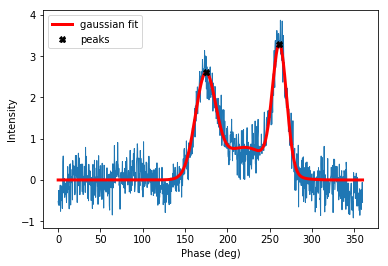

In [40]:
plot_peaks(x*(360/1024),y,profile_comp)

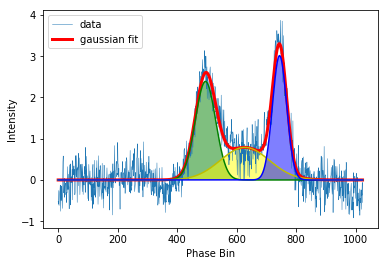

In [41]:
plot_fill(x,y,params)

#### For the EPTA data set

In [42]:
phase=highfrequencyprofile['phase']
intensity=highfrequencyprofile['intensity']
x = phase
y=[]

#Used to bring the data down, to be centred at 0
m=statistics.mean(intensity[600:])
for i in intensity:
    y.append(i-m)

In [43]:
#Calculates the noise of the data. The standard deviation of this is then the error in the data. 
noise = sigmaClip(y)
noise_std = np.nanstd(noise[1])
print(noise_std)

10.47993007576531


In [44]:
#Expected is taken from Peaks and Gaussian fittings of this frequency band
#expected=(270,30,25,370,80,20,470,20,20)
expected=(25,270,30,20,370,80,20,470,20)
params, cov, sigma = fitting_parameters(x,y,expected)
fit = threegauss(x,*params)
profile_comp = gauss_peaks(fit, 1, 0, cov, params,1396,1397)

Maxima [272.8420718611404, 456.3092761430807] [0.3766354385468707, 0.4947695740237753]
In deg component(phase=95.92104088868219, intensity=30.483901995712696) component(phase=160.4212298940518, intensity=28.20209967137492) [0.1324109  0.17394243]


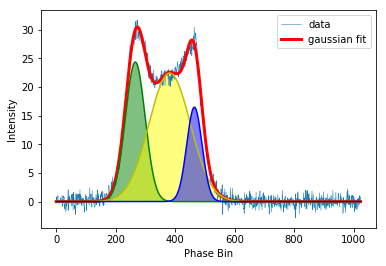

In [45]:
plot_fill(x,y,params)

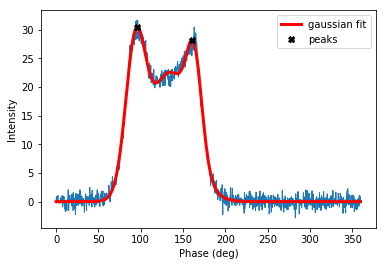

In [46]:
plot_peaks(x*(360/1024),y,profile_comp)

#### MWA Data Set

In [47]:
freqband = 1
f = averagemprofiles['frequency'] == freqband
phase=averagemprofiles['phase'][f]
intensity=averagemprofiles['intensity'][f]
x = phase
y = intensity

In [48]:
len(y)

256

In [49]:
noise = sigmaClip(y)
noise_std = np.nanstd(noise[1])
print(noise_std, noise[0])

0.017404529035323007 0.01866377025674895


In [50]:
#Taken from Peaks and Gaussian fittings of frequency band 11
#expected=(65,5,0.015,80,25,0.015,125,5,0.05,150,15,0.03)
expected=(0.015,65,5,0.015,80,25,0.05,125,5,0.03,150,15)

In [51]:
params,cov,sigma = fittingfour_parameters(x,y,expected)
fit = fourgauss(x,*params)
profile_comp = gauss_peaks(fit, nom_freq_bands, freqband, cov, params,170,200)

Maxima [66.2583929422251, 138.26637193501932] [1.5862408753672945, 0.789602015018726]
In deg component(phase=93.17586507500405, intensity=0.0350441288097292) component(phase=194.43708553362092, intensity=0.06551776896089556) [2.23065123 1.11037783]


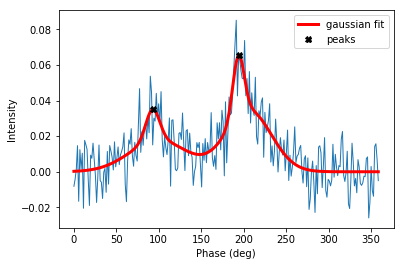

In [52]:
plot_peaks(x*(360/256),y,profile_comp)

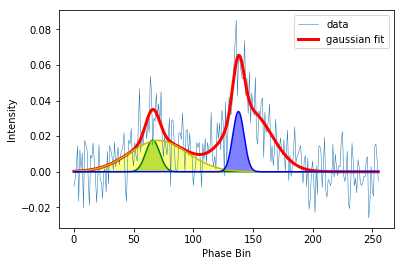

In [53]:
plot_fill(x,y,params)

#### MWA Profile

In [54]:
phase=mwaprofile['phase']
intensity=mwaprofile['intensity']
x = phase
y = intensity

In [55]:
expected=(0.04,240,40,0.02,400,100,0.06,575,45)
params,cov,sigma = fitting_parameters(x,y,expected)
fit = threegauss(x,*params)
profile_comp = gauss_peaks(fit, 1, 0, cov, params,185,186)

Maxima [268.18600695035843, 561.9151975398361] [3.048866540364818, 1.0850419422469573]
In deg component(phase=94.28414306848539, intensity=0.029275009567966387) component(phase=197.54831163509863, intensity=0.058760576124233944) [1.07186714 0.38146006]


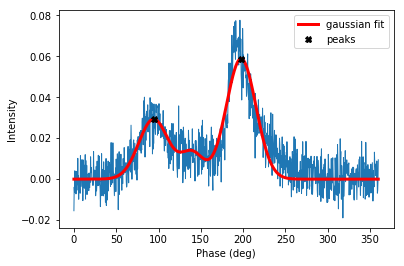

In [56]:
plot_peaks(x*(360/1024),y,profile_comp)

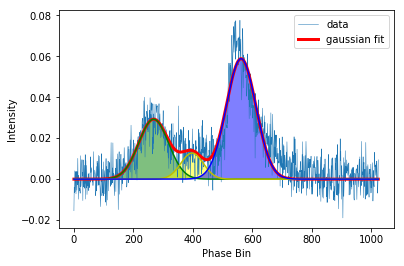

In [57]:
plot_fill(x,y,params)

# Gaussian Plotting and Finding Peaks of Overall Fit


The following is a looped version of the previous section to find the correct peaks for each pulse profile

#### GMRT Data

In [58]:
fit_components = []

In [59]:
#Taken from Peaks and Gaussian fittings of frequency band 73, in the middle
#expected=(501,30,8.02,655,80,4.07,741,20,11.29)
expected=(7,505,30,4,655,80,9,745,20)

#Loop thought all of the frequency bands
for i in range(0,no_freq_bands):
    print(i)
    freqband = i
    f = averageprofiles['frequency'] == freqband
    x=averageprofiles['phase'][f]
    y=averageprofiles['intensity'][f]
    
    #Calculates the noise of the data. The standard deviation of this is then the error in the data. 
    noise = sigmaClip(y)
    noise_std = np.nanstd(noise[1])

    #Fit the gaussians and find peaks and errors, create array with all frequencies
    #Resulting frequencies are in MHz and phase in degrees
    if len(x)!=0 and len(y)!=0:
        params,cov,sigma = fitting_parameters(x,y,expected)
        fit = threegauss(x,*params)
        profile_comp = gauss_peaks(fit, no_freq_bands, freqband, cov, params, 300, 500)
        print('Params', params, sigma)
  
        fit_components.append(profile_comp)
        print(profile_comp[1][0],profile_comp[2][0])

0
1
2
3
4
5
Params [  1.29202301 511.40827101  37.94686947   1.49228423 617.27898489
  30.02725485   2.24489237 740.49397705  40.86377971] [0.06822786 3.34489583 3.46828789 0.07632338 2.56506797 2.98178049
 0.06605438 1.60576983 1.76139484]
0 0
6
Params [3.68644712e-01 5.00815239e+02 1.29075259e+01 1.56314813e+00
 5.63366843e+02 7.97065338e+01 2.42323702e+00 7.37103860e+02
 3.92765296e+01] [0.11956962 4.57786605 5.25127377 0.05489171 4.6830538  4.13052536
 0.07230619 1.55427316 1.52987806]
0 0
7
Maxima [544.0622606552859, 746.2332111646497] [2.668782542407409, 1.6304388487429207]
In deg component(phase=191.27188851162393, intensity=2.1797924081327413) component(phase=262.34761330007217, intensity=3.2061917608008983) [0.93824386 0.57320116]
Params [  2.11123168 540.38674895  50.93281404   1.94491996 706.29715126
  63.4560937    1.64686521 750.8136008   21.55610064] [0.06744767 3.47094237 2.85936799 0.13582001 7.03043116 4.52551051
 0.1784509  1.72407895 2.34208355]
191.27188851162393 26

/home/lisasmith/.local/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/lisasmith/.local/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Maxima [524.6544186941985, 743.7624472458567] [1.1763044233557054, 0.9995429526595172]
In deg component(phase=184.44881907217916, intensity=2.9354872844104687) component(phase=261.4789853598715, intensity=3.4881666892462357) [0.41354452 0.35140182]
Params [  2.69877489 521.65324342  32.43142515   1.91260748 656.86221169
  65.42352863   2.72857927 747.72398565  25.78127157] [0.11114838 1.39911886 1.33659266 0.0540125  5.78218097 8.1218175
 0.2297198  0.94515518 1.74912236]
184.44881907217916 261.4789853598715
10
Maxima [521.0466841792786, 741.4228618317776] [1.0438478383033853, 0.8188385971863638]
In deg component(phase=183.18047490677765, intensity=3.037786358929206) component(phase=260.6564748627343, intensity=3.7308408227290615) [0.36697776 0.28787294]
Params [  2.70032484 517.65497151  33.11922065   1.92818389 665.1228426
  78.09301093   2.55626572 744.31990792  22.14848005] [0.08260118 1.09125363 1.1752224  0.05219508 4.63373047 3.61480161
 0.10308125 0.83931307 1.06920203]
183.180

Maxima [521.0759678227805, 741.978675096539] [0.7375278910209488, 0.5039605638783049]
In deg component(phase=183.19076993769627, intensity=3.821080970286585) component(phase=260.851877963627, intensity=4.664043872604946) [0.25928715 0.17717364]
Params [  3.61226468 518.44964407  36.32585914   2.13898483 660.01298105
  65.02802005   3.72269336 744.65611087  22.98768337] [0.07045672 0.90823432 0.81611977 0.04287416 3.54783076 4.27450228
 0.13932922 0.50597409 0.81934495]
183.19076993769627 260.851877963627
30
Maxima [520.2526278434076, 740.8360346038579] [0.7531707623440254, 0.5627508975126974]
In deg component(phase=182.901314476198, intensity=3.8308949972153012) component(phase=260.4501684154188, intensity=4.666851935840167) [0.2647866  0.19784211]
Params [  3.66888328 517.8720186   37.70951208   2.21807586 662.37076149
  62.65355061   3.68931825 744.27552808  24.92069809] [0.06728028 0.96771674 0.83600258 0.04836127 4.18749732 4.77401116
 0.18194617 0.56079212 0.99828217]
182.90131447

Maxima [516.9149317319284, 743.6920162637047] [0.615385682778515, 0.41118940917202085]
In deg component(phase=181.72790568700609, intensity=5.932748793088517) component(phase=261.4542244677087, intensity=7.812487905327449) [0.21634653 0.14455878]
Params [  5.45407038 513.81691465  35.6196515    3.69967389 667.65589755
  75.31672674   5.62660033 746.14414891  21.45030441] [0.08360589 0.66781059 0.66761321 0.0586671  2.5530588  2.08535782
 0.12042558 0.42453332 0.54696628]
181.72790568700609 261.4542244677087
51
Maxima [513.736926260626, 743.674512287747] [0.581520109491764, 0.40362509573163996]
In deg component(phase=180.61063813850132, intensity=5.94614209591604) component(phase=261.44807072616106, intensity=7.534308978737686) [0.20444066 0.14189945]
Params [  5.18175693 510.18919359  33.72668138   3.55989873 661.91820768
  85.5041614    5.30833506 745.87439989  21.46897495] [0.09392914 0.59498676 0.68952124 0.05135124 2.79248329 2.17443538
 0.10233327 0.4153785  0.51338722]
180.610638

Maxima [513.6425608433068, 744.8838195742217] [0.621368378567515, 0.3489125010745728]
In deg component(phase=180.57746279647503, intensity=5.883438445476111) component(phase=261.8732178190623, intensity=8.526301534650315) [0.21844982 0.12266455]
Params [  5.57171494 511.02334503  38.69604629   3.50028316 672.37301489
  72.77846993   6.42524841 746.92113002  21.13445207] [0.07299389 0.69943545 0.66813377 0.06075477 2.58959791 2.06594595
 0.12184827 0.36668225 0.47457409]
180.57746279647503 261.8732178190623
67
Maxima [511.5008535746054, 743.9630467672191] [0.6497045315746153, 0.3791973664587508]
In deg component(phase=179.82451883482221, intensity=6.239924880544297) component(phase=261.54950862910044, intensity=8.640555240953923) [0.22841175 0.13331157]
Params [  5.50792025 507.82716083  36.01179614   3.41948014 658.81405026
  84.96216937   6.59540195 745.9507398   23.13135071] [0.11135619 0.6963799  0.78360342 0.058156   3.6180277  2.76625714
 0.11875022 0.40081748 0.50498171]
179.8245

Maxima [506.4160702556451, 744.4172990904092] [0.602300837337496, 0.3693384103368762]
In deg component(phase=178.03689969925023, intensity=7.117495628446754) component(phase=261.709206711472, intensity=10.158926485171726) [0.21174639 0.12984553]
Params [  6.71223297 504.08106681  36.65496595   3.86882557 666.39701196
  75.86977561   7.91112441 746.50104882  23.04866305] [0.09485642 0.66518799 0.65799043 0.07435475 3.02460769 2.47185934
 0.15440927 0.39146802 0.51863364]
178.03689969925023 261.709206711472
86
Maxima [507.086755972679, 743.8976766759617] [0.6850430014463524, 0.39313916587137937]
In deg component(phase=178.27268764664495, intensity=6.535248729826816) component(phase=261.5265269563928, intensity=9.468633725575057) [0.24083543 0.13821299]
Params [  6.17218489 504.32730151  38.11343283   3.97855592 659.53562096
  70.31106382   7.5737049  746.43274796  24.03439111] [0.09728337 0.79371106 0.73996146 0.06771186 3.03387355 3.19155806
 0.1932947  0.40402004 0.61739976]
178.272687

Maxima [496.81213598387336, 743.9798389517539] [0.7150617108279007, 0.32553851078631446]
In deg component(phase=174.6605165568305, intensity=9.479330607073269) component(phase=261.555412131476, intensity=14.753927834822491) [0.25138888 0.11444713]
Params [  6.60039219 493.04627665  30.65723759   5.02247427 617.18120515
 115.88787371  12.00969856 745.21273938  23.81997578] [0.16716903 0.69811084 0.94209541 0.07376441 3.96175437 2.40639374
 0.16417085 0.32748589 0.41010237]
174.6605165568305 261.555412131476
120
Maxima [496.0755374894298, 743.318777652732] [0.6838641648519387, 0.3645644241111441]
In deg component(phase=174.40155614862766, intensity=10.444602465254912) component(phase=261.3230077685386, intensity=14.855044284391203) [0.240421   0.12816718]
Params [  7.05469098 493.33087922  28.06396598   5.31900146 619.37588038
 131.34880229  11.4603825  744.39496182  22.43202328] [0.16691802 0.67896327 0.833683   0.07777297 3.4981039  2.20286385
 0.17500636 0.3669311  0.42957739]
174.401

Maxima [494.89216735158425, 744.6439183776708] [1.0202223059058915, 0.4771234314868098]
In deg component(phase=173.98552758454133, intensity=3.5139123253069138) component(phase=261.7888775546499, intensity=5.5720481841890805) [0.3586719  0.16773871]
Params [  3.41140723 493.20678434  43.40073421   1.26161593 666.14248985
  76.80913466   4.82973102 745.85529598  24.22424884] [0.06807195 1.24780546 1.16038612 0.06099232 7.94995421 6.13000381
 0.12296251 0.52609151 0.69766386]
173.98552758454133 261.7888775546499
138
Maxima [484.99023405541635, 744.4013597003499] [1.0140209756939809, 0.5074960057931341]
In deg component(phase=170.5043791601073, intensity=2.8194269525164395) component(phase=261.7036030196542, intensity=4.901928986336407) [0.35649175 0.17841656]
Params [  2.77204663 483.86926662  40.70452328   1.71030236 669.14556108
  68.97368411   3.97337323 746.35074854  22.74365657] [0.05358044 1.08425514 1.0783147  0.05325825 4.5364422  3.73624676
 0.12542664 0.53090334 0.77154111]
170

#### EPTA Data

In [60]:
#Do the above but for only one frequency
#expected=(270,30,25,370,80,20,470,20,20)
expected=(25,270,30,20,370,80,20,470,20)

phase=highfrequencyprofile['phase']
intensity=highfrequencyprofile['intensity']
x = phase
y=[]

m=statistics.mean(intensity[600:])
for i in intensity:
    y.append(i-m)

if len(x)!=0 and len(y)!=0:
    params,cov,sigma = fitting_parameters(x,y,expected)
    fit = threegauss(x,*params)
    profile_compsh = gauss_peaks(fit, 1, 0, cov, params,1396,1397)

Maxima [272.8420718611404, 456.3092761430807] [0.3766354385468707, 0.4947695740237753]
In deg component(phase=95.92104088868219, intensity=30.483901995712696) component(phase=160.4212298940518, intensity=28.20209967137492) [0.1324109  0.17394243]


#### MWA Data

In [61]:
fitm_components = []

In [62]:
#Taken from Peaks and Gaussian fittings of frequency band 11, in the middle
expected=(0.015,65,5,0.015,80,25,0.05,125,5,0.03,150,15)
#Loop thought all of the frequency bands
for i in reversed(range(0,nom_freq_bands)):
    freqband = i
    
    f = averagemprofiles['frequency'] == freqband
    x=averagemprofiles['phase'][f]
    y=averagemprofiles['intensity'][f]
    
    freqband = nom_freq_bands-1-i
    
    #Calculates the noise of the data. The standard deviation of this is then the error in the data.
    noise = sigmaClip(y)
    noise_std = noise[0]

    #Fit the gaussians and find peaks and errors, create array with all frequencies
    #Resulting frequencies are in MHz and phase in degrees
    if len(x)!=0 and len(y)!=0:
        params,cov,sigma = fittingfour_parameters(x,y,expected)
        fit = fourgauss(x,*params)
        profile_comp = gauss_peaks(fit, nom_freq_bands, freqband, cov, params,169.6,200.32)
  
        fitm_components.append(profile_comp)

Maxima [66.97368891736723, 137.03732085810907] [2.349408148602189, 0.6836432980118704]
In deg component(phase=94.18175004004766, intensity=0.03262765574066159) component(phase=192.7087324567159, intensity=0.0750462149266556) [3.30385521 0.96137339]
Maxima [70.03155387277172, 138.37862030270276] [1.2486663899438144, 0.7403902430961367]
In deg component(phase=98.48187263358524, intensity=0.03510772790419399) component(phase=194.59493480067576, intensity=0.06909469452192313) [1.75593711 1.04117378]
Maxima [61.23364368473819, 136.55889977526502] [1.565864720505974, 0.6883384286431676]
In deg component(phase=86.10981143166308, intensity=0.03628959220359807) component(phase=192.03595280896644, intensity=0.0667746790091874) [2.20199726 0.96797592]
Maxima [63.920088709969164, 139.8106461742763] [1.3860786799747176, 0.6919580531669992]
In deg component(phase=89.88762474839413, intensity=0.04118731795817055) component(phase=196.60872118257603, intensity=0.06806307110976534) [1.94917314 0.9730660

#### MWA Profile

In [63]:
#Do the above but for only one frequency
expected=(0.04,240,40,0.02,400,100,0.06,575,45)

phase=mwaprofile['phase']
intensity=mwaprofile['intensity']
x = phase
y = intensity

if len(x)!=0 and len(y)!=0:
    params,cov, sigma = fitting_parameters(x,y,expected)
    fit = threegauss(x,*params)
    profile_compm = gauss_peaks(fit, 1, 0, cov, params,185,186)

Maxima [268.18600695035843, 561.9151975398361] [3.048866540364818, 1.0850419422469573]
In deg component(phase=94.28414306848539, intensity=0.029275009567966387) component(phase=197.54831163509863, intensity=0.058760576124233944) [1.07186714 0.38146006]


# Change of Peak Position over Frequency

Starting to graph out all the movement of component phase across frequency

## GMRT

### Component 1

In [64]:
#Separate the array into x and y axis of phase and frequency which can be graphed
phase_comp1=[]
frequency_comp1=[]
comp1_err=[]

for i in range(0,len(fit_components)):
    if fit_components[i][1][0] != 0:
        phase_comp1.append(fit_components[i][1][0])
        frequency_comp1.append(fit_components[i][0])
        comp1_err.append(fit_components[i][3][0])

Text(0,0.5,'Frequency')

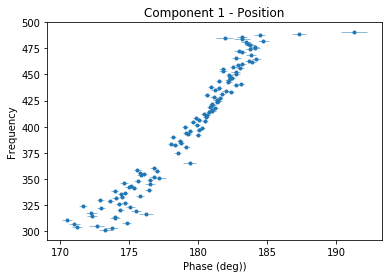

In [65]:
py.errorbar(phase_comp1,frequency_comp1, xerr=comp1_err, fmt='.', lw=0.5, label='data')
py.title('Component 1 - Position')
py.xlabel('Phase (deg))')
py.ylabel('Frequency')


In [66]:
#Remove outliers which are greater than 'threshold' number of std away from the mean
#frequency_comp1, phase_comp1, comp1_err = detect_outlier(frequency_comp1, phase_comp1, comp1_err,2)

Text(0,0.5,'Frequency')

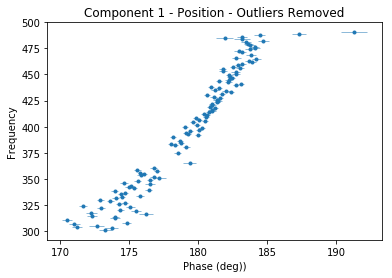

In [67]:
py.errorbar(phase_comp1,frequency_comp1, xerr=comp1_err, fmt='.', lw=0.5, label='data')
py.title('Component 1 - Position - Outliers Removed')
py.xlabel('Phase (deg))')
py.ylabel('Frequency')

In [68]:
#Fit the thorsett model to the component position
expect=(500,0.4,16)
comp1_params,comp1_cov=curve_fit(thorsett,frequency_comp1,phase_comp1, expect, maxfev=100000, sigma=comp1_err, bounds=([0,-np.inf,0],[np.inf,np.inf,np.inf]))
comp1_fit_error=np.sqrt(np.diag(comp1_cov))
comp1_fit = thorsett(frequency_comp1, *comp1_params)
#Fit a powerlaw to component position
comp1_paramspl,comp1_covpl=curve_fit(powerlaw,frequency_comp1,phase_comp1, maxfev=10000, sigma=comp1_err)
comp1_fit_errorpl=np.sqrt(np.diag(comp1_covpl))
comp1_fitpl = powerlaw(frequency_comp1, *comp1_paramspl)

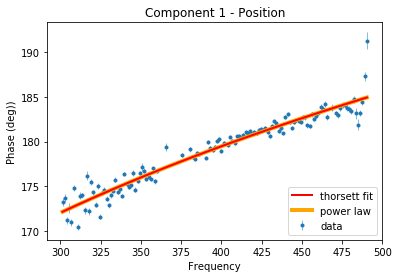

In [69]:
py.errorbar(frequency_comp1, phase_comp1, yerr=comp1_err, fmt='.', lw=0.5, label='data', zorder=0)
py.plot(frequency_comp1,comp1_fit, color='red',lw=2,label='thorsett fit', zorder=2)
py.plot(frequency_comp1,comp1_fitpl, color='orange',lw=4, label='power law', zorder=1)
py.title('Component 1 - Position')
py.ylabel('Phase (deg))')
py.xlabel('Frequency')
py.legend(loc='lower right')

In [70]:
print(f'The thorsett equation of fit for this pulse is: \t Phase = {comp1_params[0]:.3f} \u03BD^{comp1_params[1]:.3f} + {comp1_params[2]:.3f}')
print(f'The errors are {comp1_fit_error[0]}, {comp1_fit_error[1]}, {comp1_fit_error[2]} \n')

print(f'The power law equation of fit for this pulse is: \t Phase = {comp1_paramspl[0]:.3f} \u03BD^{comp1_paramspl[1]:.3f}')
print(f'The errors are {comp1_fit_errorpl[0]}, {comp1_fit_errorpl[1]}')

The thorsett equation of fit for this pulse is: 	 Phase = 74.480 ν^0.147 + 0.000
The errors are 342.6770164318243, 0.3602806547546319, 438.28393550302377 

The power law equation of fit for this pulse is: 	 Phase = 74.480 ν^0.147
The errors are 1.373292626637726, 0.003082319316638103


In [71]:
chsq_err(phase_comp1, comp1_fitpl, comp1_err)/(len(phase_comp1)-2)

8.182540830476583

### Component 2

In [72]:
#Separate the array into x and y axis of phase and frequency which can be graphed
phase_comp2=[]
frequency_comp2=[]
comp2_err=[]

for i in range(0,len(fit_components)):
    if fit_components[i][2][0] != 0:
        phase_comp2.append(fit_components[i][2][0])
        frequency_comp2.append(fit_components[i][0])
        comp2_err.append(fit_components[i][3][1])

Text(0,0.5,'Frequency')

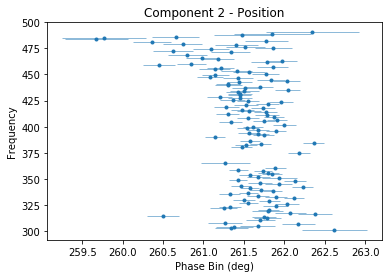

In [73]:
py.errorbar(phase_comp2,frequency_comp2, xerr=comp2_err, fmt='.', lw=0.5, label='data')
py.title('Component 2 - Position')
py.xlabel('Phase Bin (deg)')
py.ylabel('Frequency')

In [74]:
#Remove outliers which are greater than 'threshold' number of std away from the mean
#frequency_comp2, phase_comp2, comp2_err = detect_outlier(frequency_comp2, phase_comp2, comp2_err,2)

Text(0,0.5,'Frequency')

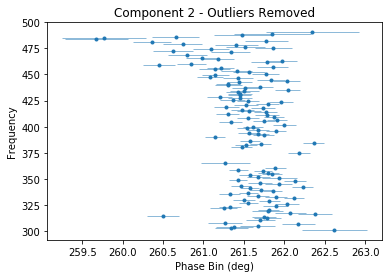

In [75]:
py.errorbar(phase_comp2,frequency_comp2, xerr=comp2_err, fmt='.', lw=0.5, label='data')
py.title('Component 2 - Outliers Removed')
py.xlabel('Phase Bin (deg)')
py.ylabel('Frequency')

In [76]:
#Fit the thorsett model to the component position
expect=(700,0.4,16)
comp2_params,comp2_cov=curve_fit(thorsett,frequency_comp2,phase_comp2, expect, maxfev=10000, sigma=comp2_err, bounds=([0,-np.inf,0],[np.inf,np.inf,np.inf]))
comp2_fit_error=np.sqrt(np.diag(comp2_cov))
comp2_fit = thorsett(frequency_comp2, *comp2_params)
#Fit a powerlaw to the component position
comp2_paramspl,comp2_covpl=curve_fit(powerlaw,frequency_comp2,phase_comp2, maxfev=10000, sigma=comp2_err)
comp2_fit_errorpl=np.sqrt(np.diag(comp2_covpl))
comp2_fitpl = powerlaw(frequency_comp2, *comp2_paramspl)

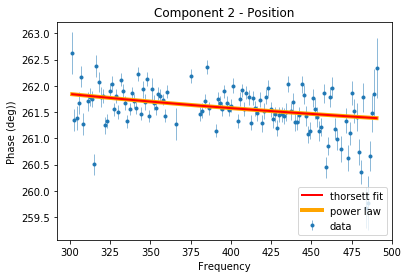

In [77]:
py.errorbar(frequency_comp2, phase_comp2, yerr=comp2_err, fmt='.', lw=0.5, label='data', zorder=0)
py.plot(frequency_comp2,comp2_fit, color='red',lw=2,label='thorsett fit', zorder=2)
py.plot(frequency_comp2,comp2_fitpl, color='orange',lw=4, label='power law', zorder=1)
py.title('Component 2 - Position')
py.ylabel('Phase (deg))')
py.xlabel('Frequency')
py.legend(loc='lower right')

In [78]:
print(f'The thorsett equation of fit for this pulse is: \t Phase = {comp2_params[0]:.3f} \u03BD^{comp2_params[1]:.3f} + {comp2_params[2]:.3f}')
print(f'The errors are {comp2_fit_error[0]}, {comp2_fit_error[1]}, {comp2_fit_error[2]} \n')

print(f'The power law equation of fit for this pulse is: \t Phase = {comp2_paramspl[0]:.3f} \u03BD^{comp2_paramspl[1]:.3f}')
print(f'The errors are {comp2_fit_errorpl[0]}, {comp2_fit_errorpl[1]}')

The thorsett equation of fit for this pulse is: 	 Phase = 267.236 ν^-0.004 + 0.005
The errors are 326602.48456042266, 4.466287146889968, 326677.40511735185 

The power law equation of fit for this pulse is: 	 Phase = 267.242 ν^-0.004
The errors are 1.4228248127720666, 0.0008946478522672583


In [79]:
chsq_err(phase_comp2, comp2_fitpl, comp2_err)/(len(phase_comp2)-2)

4.367880237479285

## MWA

## Component 1

In [80]:
#Separate the array into x and y axis of phase and frequency which can be graphed
phasem_comp1=[]
frequencym_comp1=[]
comp1m_err=[]

for i in range(0,len(fitm_components)):
    if fitm_components[i][1][0] != 0:
        phasem_comp1.append(fitm_components[i][1][0])
        frequencym_comp1.append(fitm_components[i][0])
        comp1m_err.append(fitm_components[i][3][0])

Text(0,0.5,'Frequency')

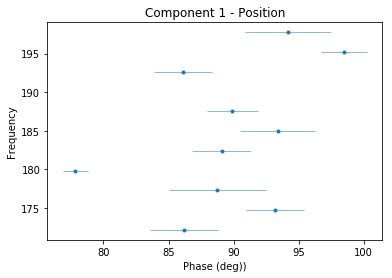

In [81]:
py.errorbar(phasem_comp1,frequencym_comp1, xerr=comp1m_err, fmt='.', lw=0.5, label='data')
py.title('Component 1 - Position')
py.xlabel('Phase (deg))')
py.ylabel('Frequency')

In [82]:
#Remove outliers which are greater than 'threshold' number of std away from the mean
#frequencym_comp1, phasem_comp1, comp1m_err = detect_outlier(frequencym_comp1, phasem_comp1, comp1m_err, 2)

Text(0,0.5,'Frequency')

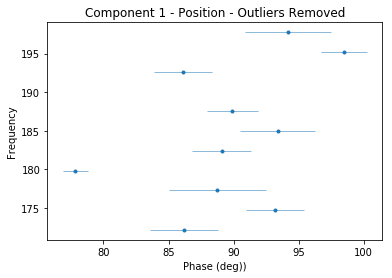

In [83]:
py.errorbar(phasem_comp1,frequencym_comp1, xerr=comp1m_err, fmt='.', lw=0.5, label='data')
py.title('Component 1 - Position - Outliers Removed')
py.xlabel('Phase (deg))')
py.ylabel('Frequency')

In [84]:
expect=(500,0.4,16)
comp1m_params,comp1m_cov=curve_fit(thorsett,frequencym_comp1,phasem_comp1, maxfev=100000, sigma=comp1m_err)
comp1m_fit_error=np.sqrt(np.diag(comp1m_cov))
comp1m_fit = thorsett(frequencym_comp1, *comp1m_params)

### Component 2

In [85]:
#Separate the array into x and y axis of phase and frequency which can be graphed
phasem_comp2=[]
frequencym_comp2=[]
comp2m_err=[]

for i in range(0,len(fitm_components)):
    if fitm_components[i][2][0] != 0:
        phasem_comp2.append(fitm_components[i][2][0])
        frequencym_comp2.append(fitm_components[i][0])
        comp2m_err.append(fitm_components[i][3][1])

Text(0,0.5,'Frequency')

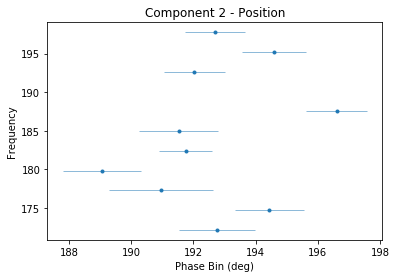

In [86]:
py.errorbar(phasem_comp2,frequencym_comp2, xerr=comp2m_err, fmt='.', lw=0.5, label='data')
py.title('Component 2 - Position')
py.xlabel('Phase Bin (deg)')
py.ylabel('Frequency')

In [87]:
#Remove outliers which are greater than 'threshold' number of std away from the mean
#frequencym_comp2, phasem_comp2, comp2m_err = detect_outlier(frequencym_comp2, phasem_comp2, comp2m_err,2 )

Text(0,0.5,'Frequency')

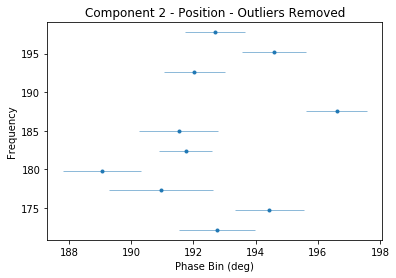

In [88]:
py.errorbar(phasem_comp2,frequencym_comp2, xerr=comp2m_err, fmt='.', lw=0.5, label='data')
py.title('Component 2 - Position - Outliers Removed')
py.xlabel('Phase Bin (deg)')
py.ylabel('Frequency')

In [89]:
#expect=(700,0.4,16)
comp2m_params,comp2m_cov=curve_fit(thorsett,frequencym_comp2,phasem_comp2, maxfev=10000, sigma=comp2m_err, bounds=([0,-1,0],[1000,0.5,np.inf]))
comp2m_fit_error=np.sqrt(np.diag(comp2m_cov))
comp2m_fit = thorsett(frequencym_comp2, *comp2m_params)

# Fitting Power Laws to Separation 

## Just GMRT

In [90]:
component_sep, sep_error = separation_singleprofile(fit_components)

In [91]:
comp_sep=[]
frequency_forsep=[]

#range(0,no_freq_bands)
for i in range(0,len(component_sep)):
    comp_sep.append(component_sep[i][1])
    frequency_forsep.append(component_sep[i][0])

Text(0,0.5,'Δθ (deg)')

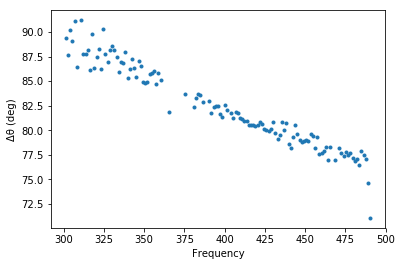

In [92]:
py.plot(frequency_forsep, comp_sep, '.')
py.xlabel('Frequency')
py.ylabel('\u0394\u03B8 (deg)')

In [93]:
frequency_forsep, comp_sep, sep_error = detect_outlier(frequency_forsep, comp_sep, sep_error, 2.5)

Text(0,0.5,'Δθ (deg)')

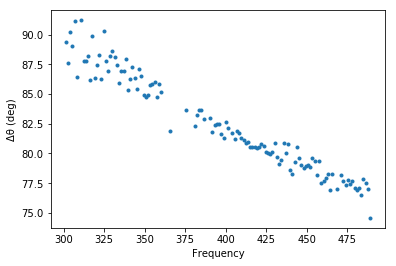

In [94]:
py.plot(frequency_forsep, comp_sep, '.')
py.xlabel('Frequency')
py.ylabel('\u0394\u03B8 (deg)')

In [95]:
expect=(703,0.4,16)
sep_params,sep_cov=curve_fit(thorsett,frequency_forsep,comp_sep, expect, maxfev=10000, sigma=sep_error, bounds=([0,-1,-np.inf],[np.inf,0.5,np.inf]))
sep_fit_error=np.sqrt(np.diag(sep_cov))
separation_fit=thorsett(frequency_forsep,*sep_params)

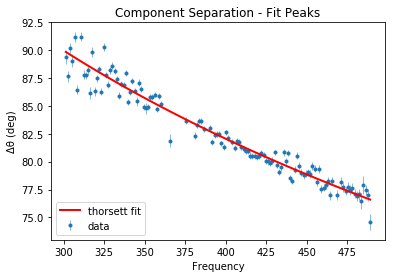

In [96]:
#py.plot(frequency_forsep, comp_sep, '.', label='data')
py.errorbar(frequency_forsep, comp_sep, yerr=sep_error, fmt='.', lw=0.5, label='data',zorder=1)
py.plot(frequency_forsep,separation_fit, color='red',lw=2,label='thorsett fit',zorder=2)
py.title('Component Separation - Fit Peaks')
py.xlabel('Frequency')
py.ylabel('\u0394\u03B8 (deg)')
py.legend(loc='lower left')


In [97]:
#chi, p = sp.stats.chisquare(comp_sep, separation_fit)
print(f'The equation of fit for this pulsar is: \t \u0394\u03B8 = {sep_params[0]:.3f} \u03BD^{sep_params[1]:.3f} + {sep_params[2]:.3f} \n')
print(f'The errors are {sep_fit_error[0]:.3f}, {sep_fit_error[1]:.3f}, {sep_fit_error[2]:.3f} ')
#print('The chi squared value for the fit is: ', chi)
print('Units for \u0394\u03B8 is degrees and \u03BD is MHz')

The equation of fit for this pulsar is: 	 Δθ = 658.219 ν^-0.059 + -380.062 

The errors are 2539.474, 0.351, 2755.185 
Units for Δθ is degrees and ν is MHz


##  MWA and GMRT

In [98]:
y_sep=comp_sep.copy()
x_sep=frequency_forsep.copy()
err_sep=sep_error.copy()

In [99]:
componentm_sep, sepm_error = separation_singleprofile(fitm_components)

In [100]:
compm_sep=[]
frequencym_forsep=[]

In [101]:
for i in range(0,len(componentm_sep)):
    compm_sep.append(componentm_sep[i][1])
    frequencym_forsep.append(componentm_sep[i][0])

In [102]:
#frequencym_forsep, compm_sep, sepm_error = detect_outlier(frequencym_forsep, compm_sep, sepm_error, 1)

In [103]:
for j in range(0,len(compm_sep)):
    comp_sep.append(compm_sep[j])
    frequency_forsep.append(frequencym_forsep[j])
    sep_error.append(sepm_error[j])

In [104]:
expect=(703,0.4,16)
sep_params,sep_cov=curve_fit(thorsett,frequency_forsep,comp_sep, expect, maxfev=10000, sigma=sep_error, bounds=([0,-1,-np.inf],[np.inf,0.5,np.inf]))
sep_fit_error=np.sqrt(np.diag(sep_cov))
separation_fit=thorsett(frequency_forsep,*sep_params)

## GMRT/MWA/EPTA

In [105]:
h_fit_components=[]

In [106]:
h_fit_components.insert(0,profile_compsh)

In [107]:
h_component_sep,h_sep_error = separation_singleprofile(h_fit_components)

In [108]:
comp_sep.insert(0,h_component_sep[0][1])
frequency_forsep.insert(0,h_component_sep[0][0])
sep_error.insert(0, h_sep_error[0])

In [109]:
expect=(703,0.4,16)
sep_params,sep_cov=curve_fit(thorsett,frequency_forsep,comp_sep, expect, maxfev=10000, sigma=sep_error, bounds=([0,-np.inf,-np.inf],[np.inf,0.5,np.inf]))
sep_fit_error=np.sqrt(np.diag(sep_cov))

In [110]:
sepa_fit=[]
x_sepa_fit=list(range(100,1400))
sepa_fit_errors=[]
for i in x_sepa_fit:
    sepa_fit.append(sep_params[0]*(i**(sep_params[1]))+sep_params[2])
    sepa_fit_errors.append(np.sqrt(((i**(sep_params[1])*(sep_fit_error[0]))**2)+(((np.log(i)*sep_params[0]*i**(sep_params[1]))*(sep_fit_error[1]))**2)+((1*(sep_fit_error[2]))**2)))

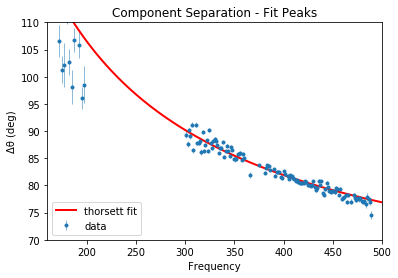

In [111]:
#py.plot(frequency_forsep, comp_sep, '.', label='data')
py.errorbar(frequency_forsep, comp_sep, yerr=sep_error, fmt='.', lw=0.5, label='data')
py.plot(x_sepa_fit,sepa_fit, color='red',lw=2,label='thorsett fit')
#py.axis((290,500,70,95))
py.axis((160,500,70,110))
#py.axis((125,1500,62,110))
py.title('Component Separation - Fit Peaks')
py.xlabel('Frequency')
py.ylabel('\u0394\u03B8 (deg)')
py.legend(loc='lower left')

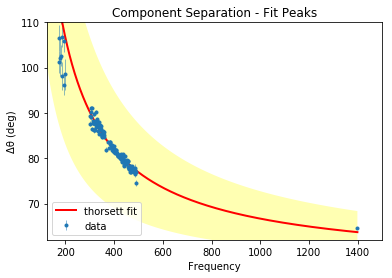

In [112]:
py.errorbar(frequency_forsep, comp_sep, yerr=sep_error, fmt='.', lw=0.5, label='data')
py.plot(x_sepa_fit,sepa_fit, color='red',lw=2,label='thorsett fit')
py.fill_between(x_sepa_fit, np.array(sepa_fit) - np.array(sepa_fit_errors), np.array(sepa_fit) + np.array(sepa_fit_errors), facecolor='yellow', alpha=0.3)
#py.axis((290,500,70,95))
#py.axis((160,500,70,110))
py.axis((125,1500,62,110))
py.title('Component Separation - Fit Peaks')
py.xlabel('Frequency')
py.ylabel('\u0394\u03B8 (deg)')
py.legend(loc='lower left')

In [113]:
print(f'The equation of fit for this pulsar is: \t \u0394\u03B8 = {sep_params[0]:.3f} \u03BD^{sep_params[1]:.3f} + {sep_params[2]:.3f} \n')
print(f'The errors are {sep_fit_error[0]:.3f}, {sep_fit_error[1]:.3f}, {sep_fit_error[2]:.3f} ')
print('Units for \u0394\u03B8 is degrees and \u03BD is MHz')

The equation of fit for this pulsar is: 	 Δθ = 8187.930 ν^-0.960 + 55.854 

The errors are 2614.679, 0.063, 1.599 
Units for Δθ is degrees and ν is MHz


### GMRT, PARKES and MWA Profile

In [114]:
y_sep.insert(0,h_component_sep[0][1])
x_sep.insert(0,h_component_sep[0][0])
err_sep.insert(0, h_sep_error[0])

In [115]:
m_fit_components=[]
m_fit_components.insert(0,profile_compm)
m_component_sep,m_sep_error = separation_singleprofile(m_fit_components)

In [116]:
m_component_sep

[component_separation(frequency=186.0, separation=103.26416856661324)]

In [117]:
y_sep.append(m_component_sep[0][1])
x_sep.append(m_component_sep[0][0])
err_sep.append(m_sep_error[0])

In [118]:
expect=(703,0.4,16)
sep_params,sep_cov=curve_fit(thorsett,x_sep,y_sep, expect, sigma=err_sep, maxfev=10000,  bounds=([0,-np.inf,-np.inf],[np.inf,0.5,np.inf]))
sep_fit_error=np.sqrt(np.diag(sep_cov))

In [119]:
sepa_fit=[]
x_sepa_fit=list(range(100,1400))
sepa_fit_errors=[]
for i in x_sepa_fit:
    sepa_fit.append(sep_params[0]*(i**(sep_params[1]))+sep_params[2])
    sepa_fit_errors.append(np.sqrt(((i**(sep_params[1])*(sep_fit_error[0]))**2)+(((np.log(i)*sep_params[0]*i**(sep_params[1]))*(sep_fit_error[1]))**2)+((1*(sep_fit_error[2]))**2)))

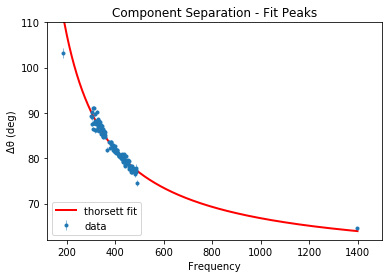

In [120]:
#py.plot(frequency_forsep, comp_sep, '.', label='data')
py.errorbar(x_sep, y_sep, yerr=err_sep, fmt='.', lw=0.5, label='data')
py.plot(x_sepa_fit,sepa_fit, color='red',lw=2,label='thorsett fit')
#py.axis((290,500,70,95))
#py.axis((160,500,70,110))
py.axis((120,1500,62,110))
py.title('Component Separation - Fit Peaks')
py.xlabel('Frequency')
py.ylabel('\u0394\u03B8 (deg)')
py.legend(loc='lower left')

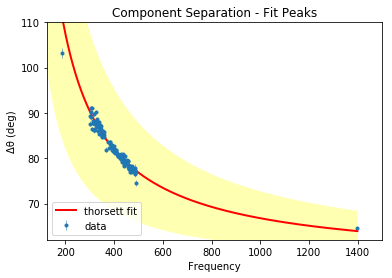

In [121]:
py.errorbar(x_sep, y_sep, yerr=err_sep, fmt='.', lw=0.5, label='data')
py.plot(x_sepa_fit,sepa_fit, color='red',lw=2,label='thorsett fit')
py.fill_between(x_sepa_fit, np.array(sepa_fit) - np.array(sepa_fit_errors), np.array(sepa_fit) + np.array(sepa_fit_errors), facecolor='yellow', alpha=0.3)
#py.axis((290,500,70,95))
#py.axis((160,500,70,110))
py.axis((125,1500,62,110))
py.title('Component Separation - Fit Peaks')
py.xlabel('Frequency')
py.ylabel('\u0394\u03B8 (deg)')
py.legend(loc='lower left')

In [122]:
print(f'The equation of fit for this pulsar is: \t \u0394\u03B8 = {sep_params[0]:.3f} \u03BD^{sep_params[1]:.3f} + {sep_params[2]:.3f} \n')
print(f'The errors are {sep_fit_error[0]:.3f}, {sep_fit_error[1]:.3f}, {sep_fit_error[2]:.3f} ')
print('Units for \u0394\u03B8 is degrees and \u03BD is MHz')

The equation of fit for this pulsar is: 	 Δθ = 10975.187 ν^-1.016 + 56.917 

The errors are 3820.157, 0.068, 1.530 
Units for Δθ is degrees and ν is MHz


# Change in Intensity over Frequency

## Fit Peaks (fit_components)

In [123]:
intensity_comp1=[]
frequency_comp1=[]

for i in range(0,len(fit_components)):
  if fit_components[i][1][0] != 0:
    intensity_comp1.append(fit_components[i][1][1])
    frequency_comp1.append(fit_components[i][0])

Text(0,0.5,'Intensity')

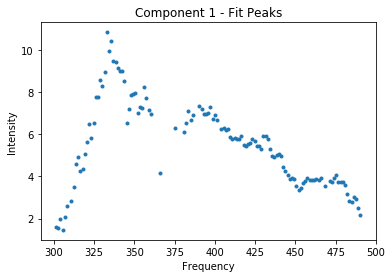

In [124]:
py.plot(frequency_comp1,intensity_comp1, '.')
py.title('Component 1 - Fit Peaks')
py.xlabel('Frequency')
py.ylabel('Intensity')

In [125]:
intensity_comp2=[]
frequency_comp2=[]

for i in range(0,len(fit_components)):
  if fit_components[i][1][0] != 0:
    intensity_comp2.append(fit_components[i][2][1])
    frequency_comp2.append(fit_components[i][0])

Text(0,0.5,'Intensity')

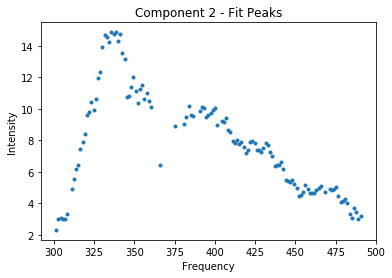

In [126]:
py.plot(frequency_comp2,intensity_comp2, '.')
py.title('Component 2 - Fit Peaks')
py.xlabel('Frequency')
py.ylabel('Intensity')

# Intensity Fitting

In [127]:
int1_params,int1_cov=curve_fit(thorsett,frequency_ind1,intensity_ind1, maxfev=10000)
int1_error=np.sqrt(np.diag(int1_cov))

NameError: name 'frequency_ind1' is not defined

In [ ]:
int1_fit = thorsett(frequency_ind1, *int1_params)

In [ ]:
py.plot(frequency_ind1, intensity_ind1, lw=0.5, label='data')
py.plot(frequency_ind1, int1_fit, color='red',lw=1,label='power fit')
py.xlabel('Frequency')
py.ylabel('\u0394\u03B8 (deg)')

In [ ]:
int2_params,int2_cov=curve_fit(thorsett,frequency_ind2,intensity_ind2, maxfev=10000)
int2_error=np.sqrt(np.diag(int2_cov))

In [ ]:
int2_fit = thorsett(frequency_ind2, *int2_params)

In [ ]:
py.plot(frequency_ind2, intensity_ind2, lw=0.5, label='data')
py.plot(frequency_ind2, int1_fit, color='red',lw=1,label='power fit')
py.xlabel('Frequency')
py.ylabel('\u0394\u03B8 (deg)')

# Change in Width over Frequency

In [ ]:
width_ind1=[]
frequency_ind1=[]

for i in range(0,len(ind_components)):
  if ind_components[i][1][0] != 0:
    width_ind1.append(ind_components[i][1][2])
    frequency_ind1.append(ind_components[i][0])

In [ ]:
py.plot(frequency_ind1,width_ind1, '.')
py.title('Component 1 - Individual Peaks')
py.xlabel('Frequency')
py.ylabel('Width (deg)')

In [ ]:
width_ind2=[]
frequency_ind2=[]

for i in range(0,len(ind_components)):
  if ind_components[i][1][0] != 0:
    width_ind2.append(ind_components[i][2][2])
    frequency_ind2.append(ind_components[i][0])

In [ ]:
py.plot(frequency_ind2,width_ind2, '.')
py.title('Component 2 - Individual Peaks')
py.xlabel('Frequency')
py.ylabel('Width (deg)')

# Width Fitting

In [ ]:
wid1_params,wid1_cov=curve_fit(thorsett,frequency_ind1,width_ind1, maxfev=10000)
wid1_error=np.sqrt(np.diag(wid1_cov))

In [ ]:
wid1_fit = thorsett(frequency_ind1, *wid1_params)

In [ ]:
py.plot(frequency_ind1, width_ind1, lw=0.5, label='data')
py.plot(frequency_ind1,wid1_fit, color='red',lw=1,label='power fit')
py.xlabel('Frequency')
py.ylabel('\u0394\u03B8 (deg)')

In [ ]:
wid2_params,wid2_cov=curve_fit(thorsett,frequency_ind2,width_ind2, maxfev=10000)
wid2_error=np.sqrt(np.diag(wid2_cov))

In [ ]:
wid2_fit = thorsett(frequency_ind2, *wid2_params)

In [ ]:
py.plot(frequency_ind2, width_ind2, lw=0.5, label='data')
py.plot(frequency_ind2, wid2_fit, color='red',lw=1,label='power fit')
py.xlabel('Frequency')
py.ylabel('\u0394\u03B8 (deg)')